In [1]:
%load_ext autoreload
%autoreload 2

#Setting Up and Importing the Necessary Packages/Libraries
##Package for reading in Bruker OPUS type files
from brukeropusreader import read_file
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import pathlib
import numpy as np
import pandas as pd
#Local Functions
from hydrogenase_processing.cut_range import cut_range_subtraction, cut_range_subtraction_multiple_wv
from hydrogenase_processing.second_deriv import second_deriv, first_deriv
from hydrogenase_processing.anchor_points import get_peaks, get_start_end_anchorpoints, get_all_anchor_points
from hydrogenase_processing.vaporfit import atm_subtraction
from hydrogenase_processing.vaporfit import AtmFitParams
#testing
#find peaks
from scipy.signal import find_peaks, peak_widths


In [2]:
#Paths to Local Data
path_to_water_vapor_data = pathlib.Path("../../data/opus_files/water_vapor")
path_to_output_plots_= pathlib.Path("../../data/output_plots/")
path_to_pD6_data = pathlib.Path("../../data/opus_files/pD6")

In [3]:
#Pulling in all pD6 sample data
pD6_raw_files = list(path_to_pD6_data.iterdir())
pD6_raw_files.sort()

#Initializing dict of raw spectra files from the file system
pD6_raw_data = dict()

#Populating the raw_test_data dict with all the read in raw opus files
##Using the last 5 characters, as they are the uniquely identifying portions of each of the file names
for i in pD6_raw_files:
    if not i.name.startswith('.DS_Store'):
        pD6_raw_data[f'pD6_{i.name[-5:len(i.name)]}'] = read_file(i)

print(pD6_raw_data.keys())

dict_keys(['pD6_.0000', 'pD6_.0001', 'pD6_.0002', 'pD6_.0003', 'pD6_.0004', 'pD6_.0005', 'pD6_.0006', 'pD6_.0007', 'pD6_.0008', 'pD6_.0009', 'pD6_.0010', 'pD6_.0011', 'pD6_.0012', 'pD6_.0013', 'pD6_.0014', 'pD6_.0015', 'pD6_.0016', 'pD6_.0017', 'pD6_.0018', 'pD6_.0019', 'pD6_.0020', 'pD6_.0021', 'pD6_.0022', 'pD6_.0023', 'pD6_.0024', 'pD6_.0025', 'pD6_OCP.0'])


In [4]:
#Pulling in all wv data
water_vapor_files = list(path_to_water_vapor_data.iterdir())
water_vapor_files.sort()
#Initializing dict of wv_files from the file system
water_vapor_data = dict()

#Populating the water_vapor_data dict with all the read in wv opus files
#making sure names(keys) are distinct by subscripting
for i in (water_vapor_files):
    if not i.name.startswith('.DS_Store'):
        water_vapor_data[f'wv_{i.name[-6:len(i.name)]}_data'] = read_file(i)

print(water_vapor_data.keys())

dict_keys(['wv_s.0000_data', 'wv_w.0000_data', 'wv_w.0001_data', 'wv_w.0002_data', 'wv_w.0003_data', 'wv_w.0004_data'])


In [5]:
#Pulling in config file for pD6 samples
pd6_config_df = pd.read_excel("../../data/prospecpy_config.xlsx", sheet_name="hyd2_pD_6")
#Cutting names in file_name column to match the imported files
pd6_config_df["file_name"] = pd6_config_df["file_name"].apply(lambda file_name: f'pD6_{file_name[-5:len(file_name)]}') 


#Indexing the config dataframe by file_name for simultaneous parsing with the pD6_raw_data dict below
indexed_pD6_config_df = pd6_config_df.set_index('file_name')
print(indexed_pD6_config_df)

           range_start  range_end  Notes
file_name                               
pD6_.0000         2150       1850    NaN
pD6_.0001         2150       1850    NaN
pD6_.0002         2150       1850    NaN
pD6_.0003         2150       1850    NaN
pD6_.0004         2150       1850    NaN
pD6_.0005         2150       1850    NaN
pD6_.0006         2150       1850    NaN
pD6_.0007         2150       1850    NaN
pD6_.0008         2150       1850    NaN
pD6_.0009         2150       1850    NaN
pD6_.0010         2150       1850    NaN
pD6_.0011         2150       1850    NaN
pD6_.0012         2150       1850    NaN
pD6_.0013         2150       1850    NaN
pD6_.0014         2150       1850    NaN
pD6_.0015         2150       1850    NaN
pD6_.0016         2150       1850    NaN
pD6_.0017         2150       1850    NaN
pD6_.0018         2150       1850    NaN
pD6_.0019         2150       1850    NaN
pD6_.0020         2150       1850    NaN
pD6_.0021         2150       1850    NaN
pD6_.0022       

In [6]:
#Initializing dict of post water vapor subtraction spectra
cut_range_sub_wv_data = dict()


for idx, row in indexed_pD6_config_df.iterrows():  
    print(idx)
    if idx in pD6_raw_data:
        raw_data_i = pD6_raw_data[idx]
        cut_range_sub_wv_data[f'{idx}_cut_range_sub_wv'] = cut_range_subtraction_multiple_wv(raw_data_i, water_vapor_data, row["range_start"], row["range_end"], SG_poly = 3, SG_points = 21)
    


pD6_.0000
wv_s.0000_data
wv_w.0000_data
wv_w.0001_data
wv_w.0002_data
wv_w.0003_data
wv_w.0004_data
2150.0 1850.0
959 1115
pD6_.0001
wv_s.0000_data
wv_w.0000_data
wv_w.0001_data
wv_w.0002_data
wv_w.0003_data
wv_w.0004_data
2150.0 1850.0
959 1115
pD6_.0002
wv_s.0000_data
wv_w.0000_data
wv_w.0001_data
wv_w.0002_data
wv_w.0003_data
wv_w.0004_data
2150.0 1850.0
959 1115
pD6_.0003
wv_s.0000_data
wv_w.0000_data
wv_w.0001_data
wv_w.0002_data
wv_w.0003_data
wv_w.0004_data
2150.0 1850.0
959 1115
pD6_.0004
wv_s.0000_data
wv_w.0000_data
wv_w.0001_data
wv_w.0002_data
wv_w.0003_data
wv_w.0004_data
2150.0 1850.0
959 1115
pD6_.0005
wv_s.0000_data
wv_w.0000_data
wv_w.0001_data
wv_w.0002_data
wv_w.0003_data
wv_w.0004_data
2150.0 1850.0
959 1115
pD6_.0006
wv_s.0000_data
wv_w.0000_data
wv_w.0001_data
wv_w.0002_data
wv_w.0003_data
wv_w.0004_data
2150.0 1850.0
959 1115
pD6_.0007
wv_s.0000_data
wv_w.0000_data
wv_w.0001_data
wv_w.0002_data
wv_w.0003_data
wv_w.0004_data
2150.0 1850.0
959 1115
pD6_.0008
wv_s.0

pD6_.0000_cut_range_sub_wv


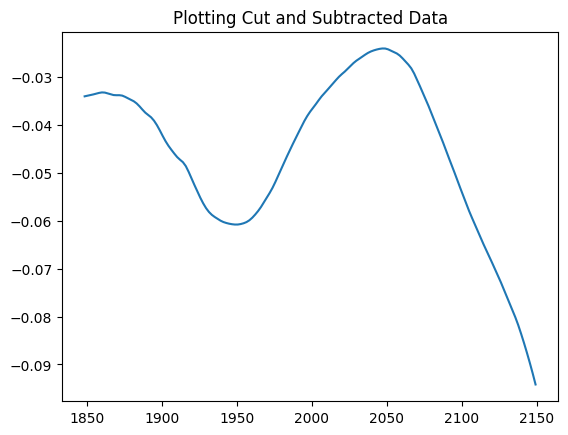

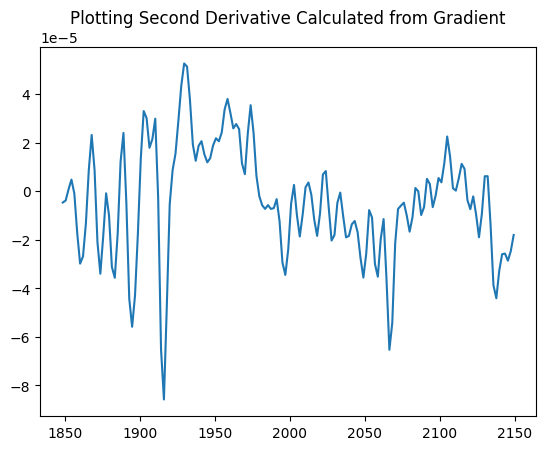

pD6_.0001_cut_range_sub_wv


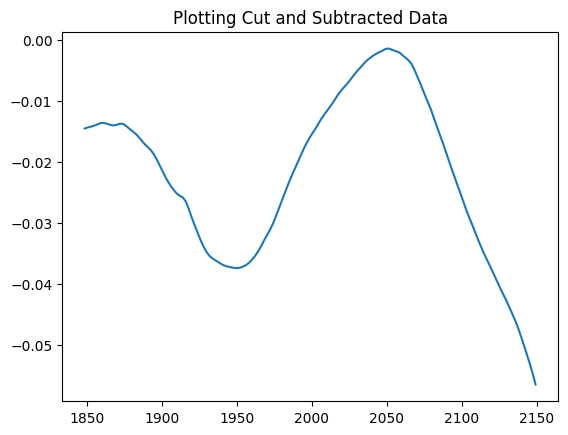

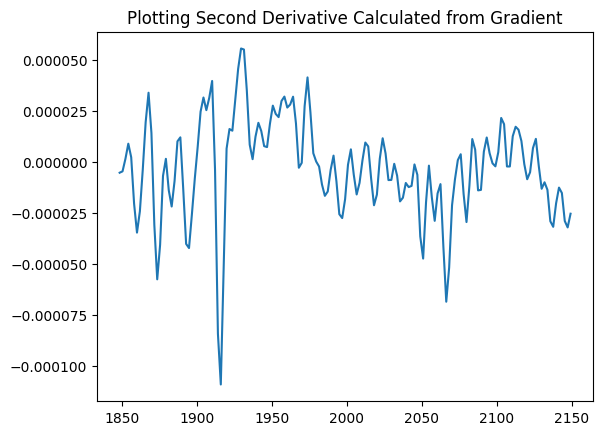

pD6_.0002_cut_range_sub_wv


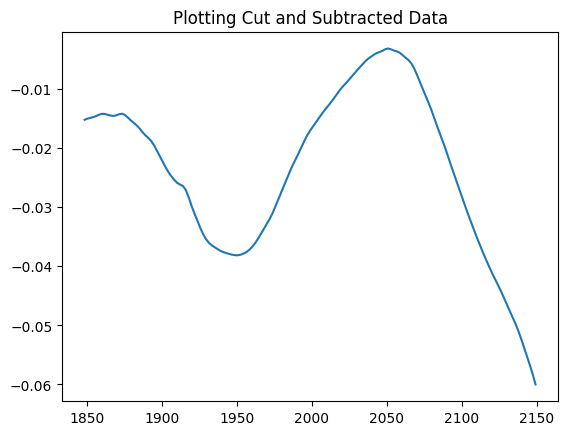

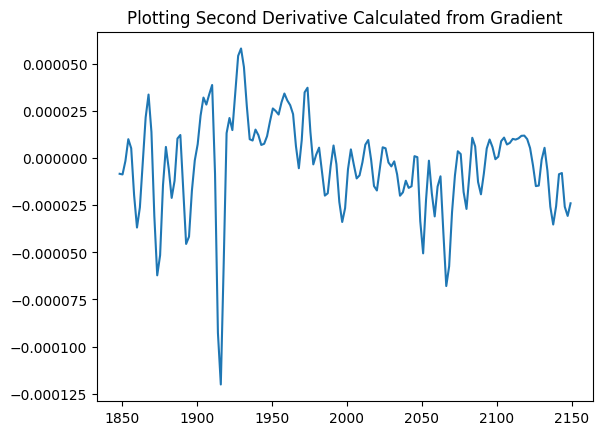

pD6_.0003_cut_range_sub_wv


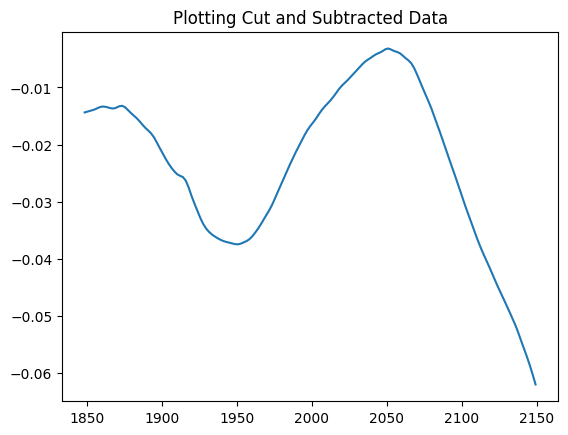

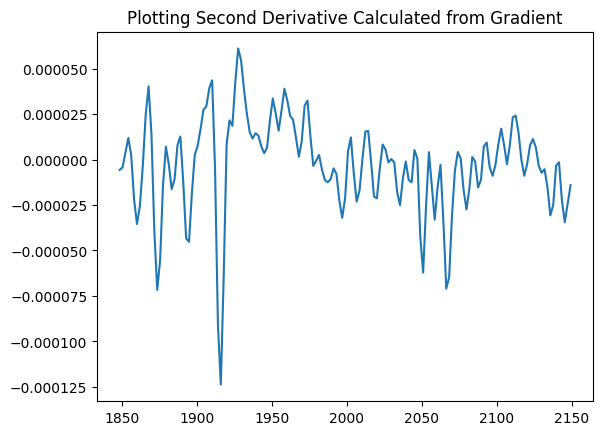

pD6_.0004_cut_range_sub_wv


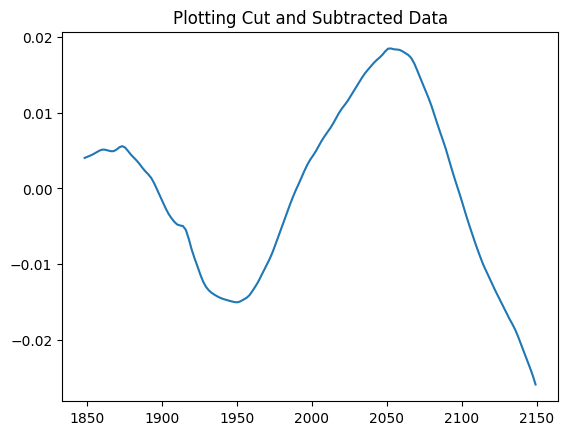

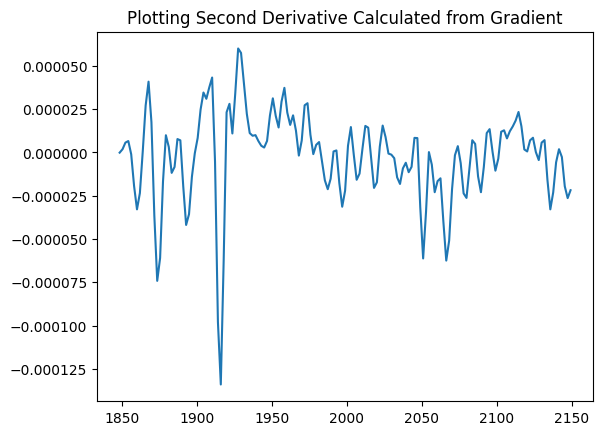

pD6_.0005_cut_range_sub_wv


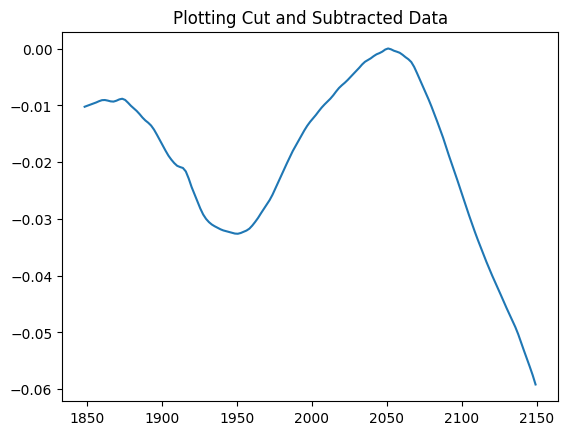

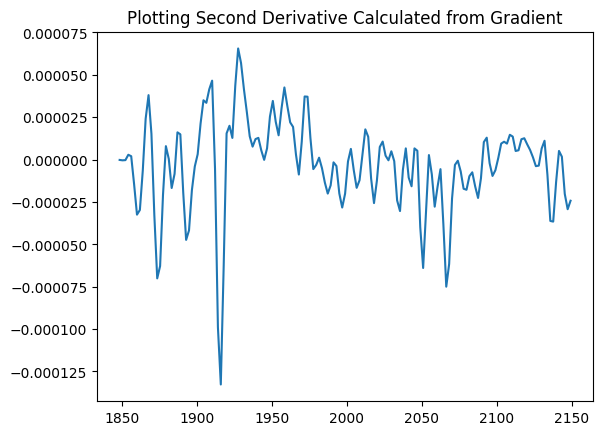

pD6_.0006_cut_range_sub_wv


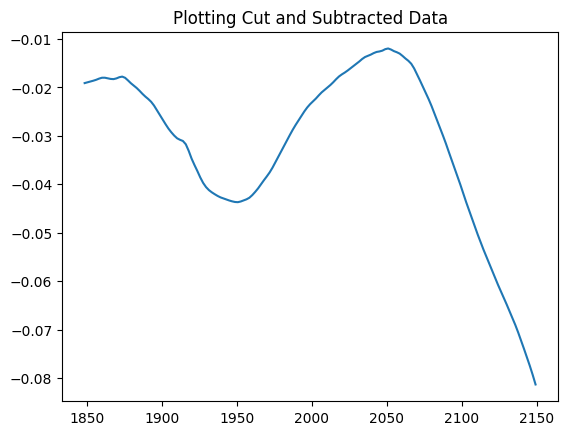

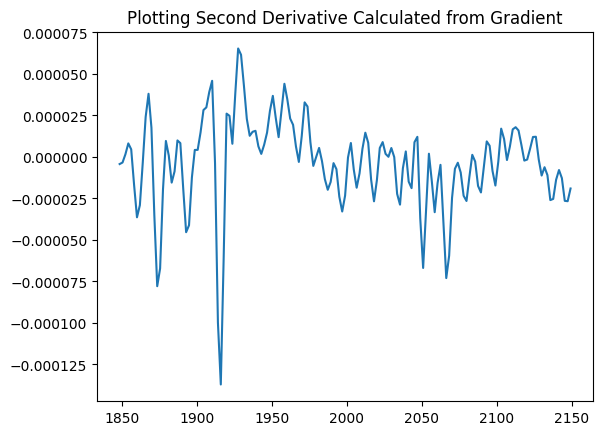

pD6_.0007_cut_range_sub_wv


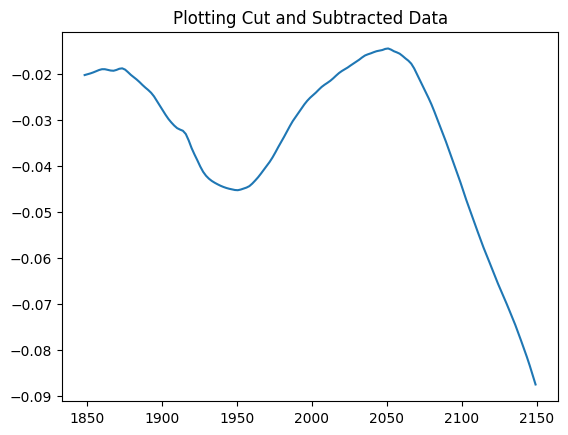

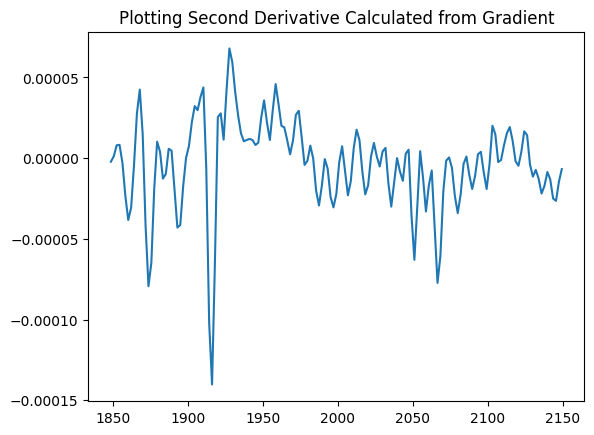

pD6_.0008_cut_range_sub_wv


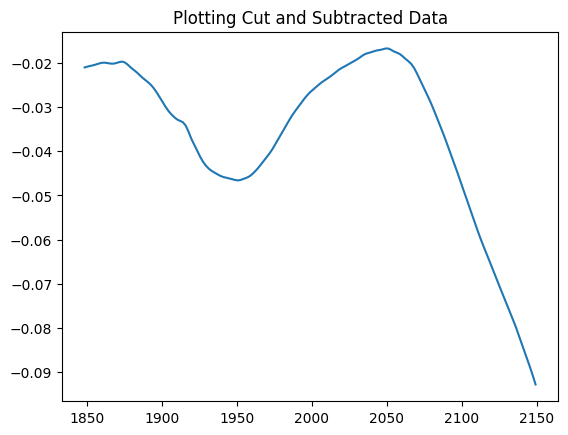

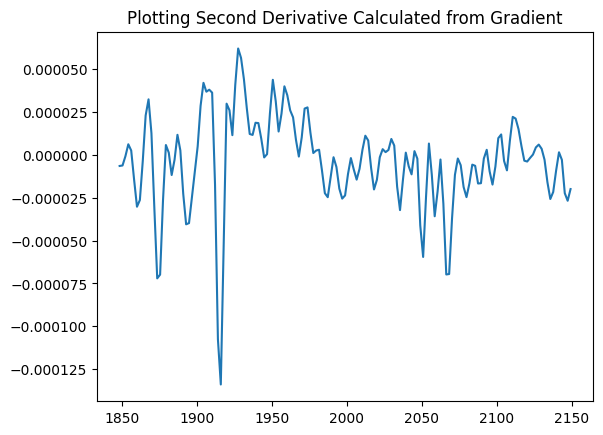

pD6_.0009_cut_range_sub_wv


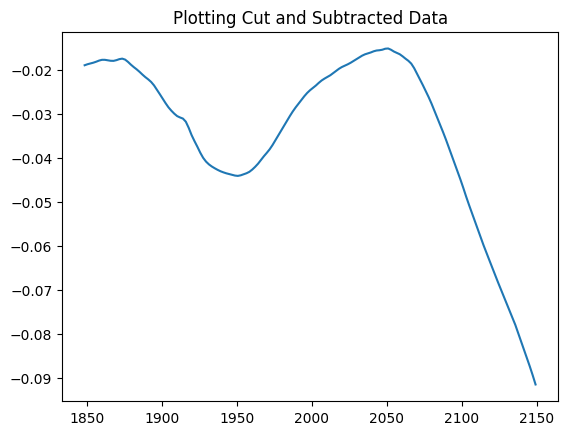

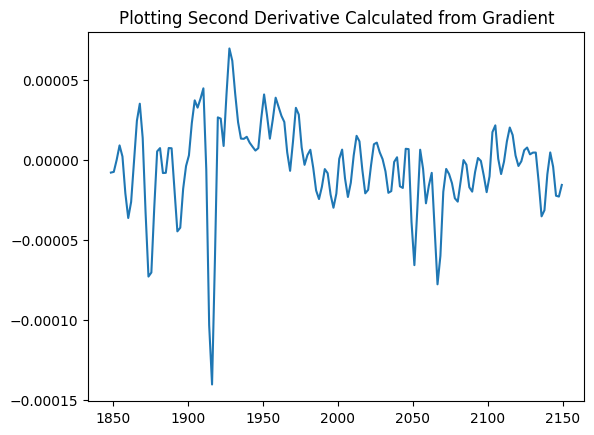

pD6_.0010_cut_range_sub_wv


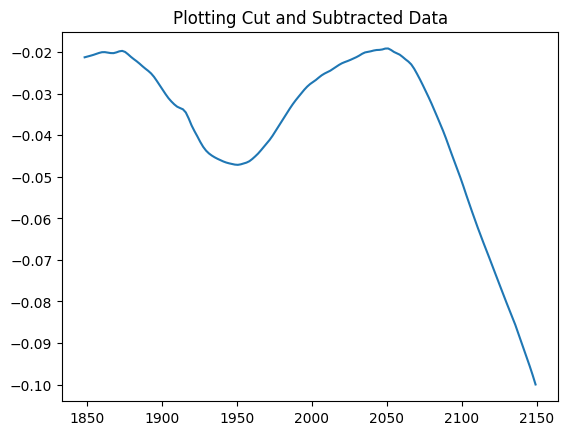

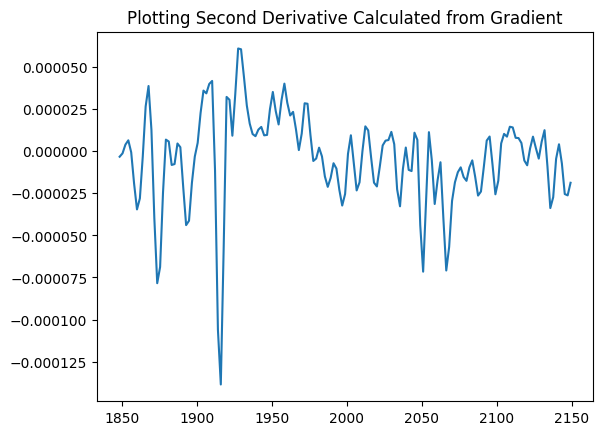

pD6_.0011_cut_range_sub_wv


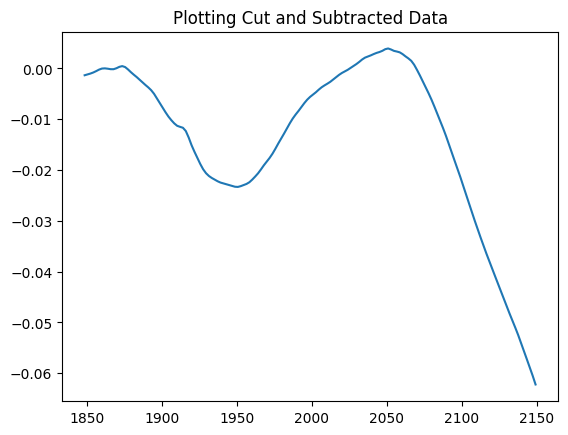

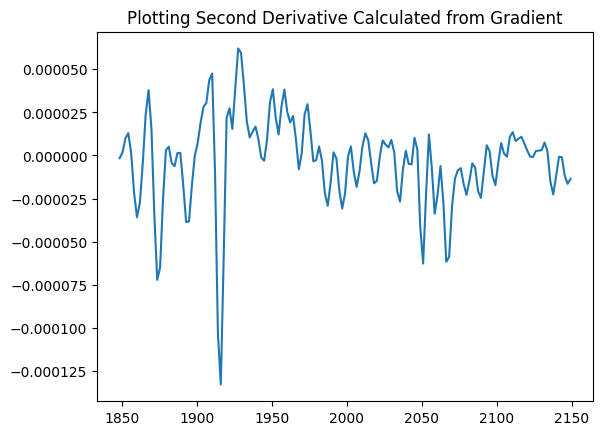

pD6_.0012_cut_range_sub_wv


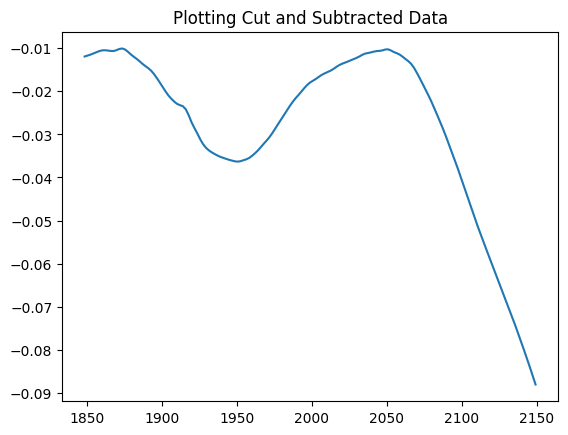

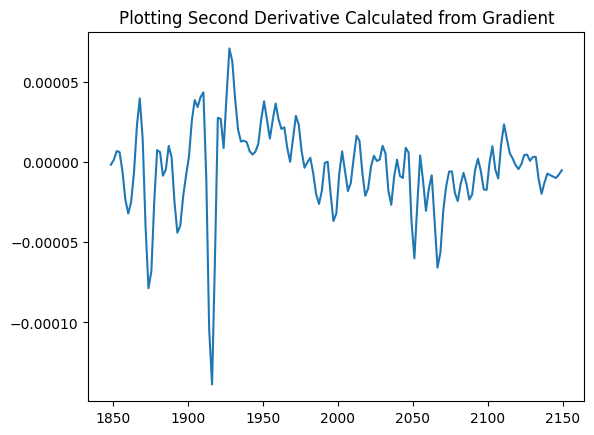

pD6_.0013_cut_range_sub_wv


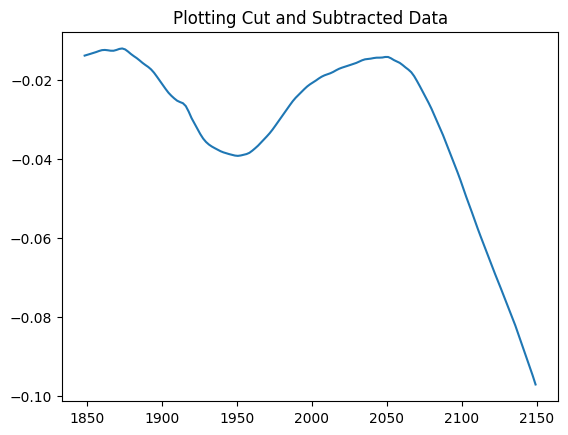

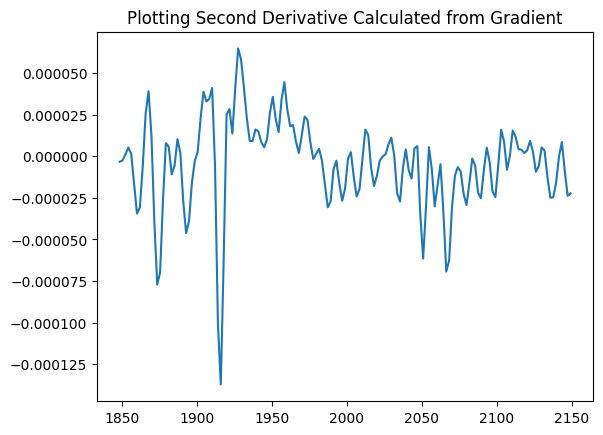

pD6_.0014_cut_range_sub_wv


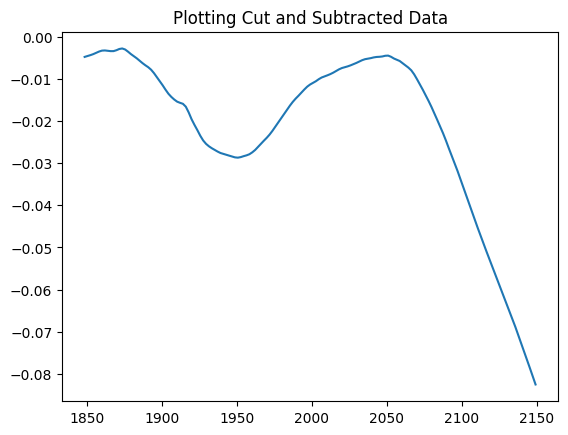

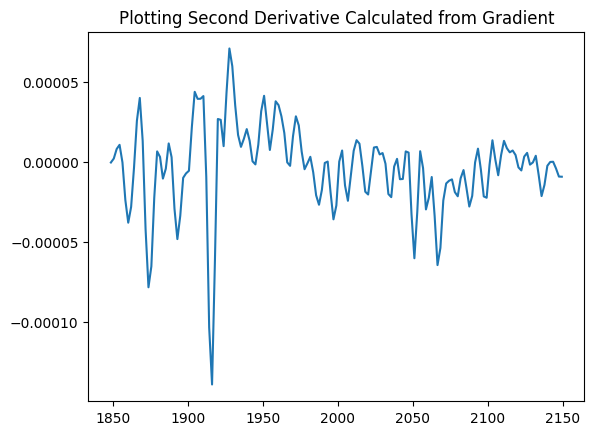

pD6_.0015_cut_range_sub_wv


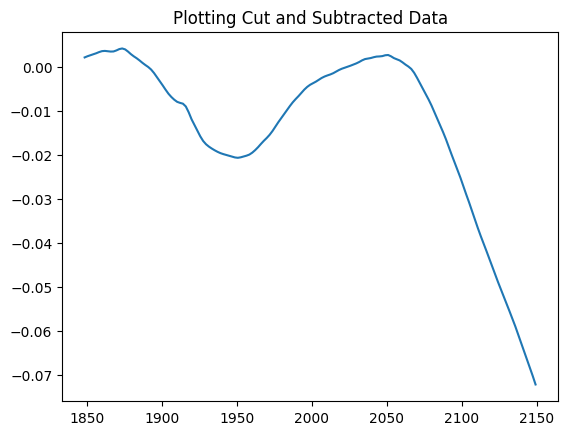

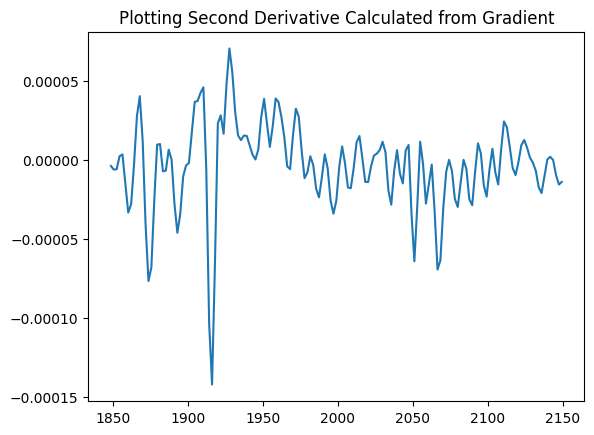

pD6_.0016_cut_range_sub_wv


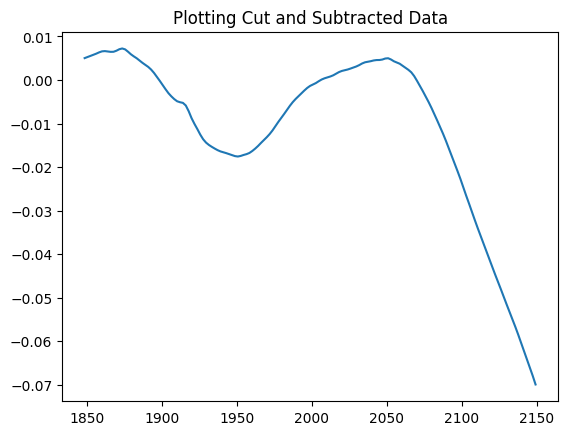

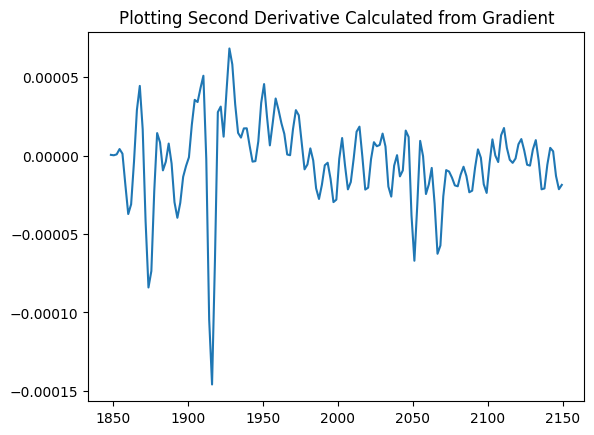

pD6_.0017_cut_range_sub_wv


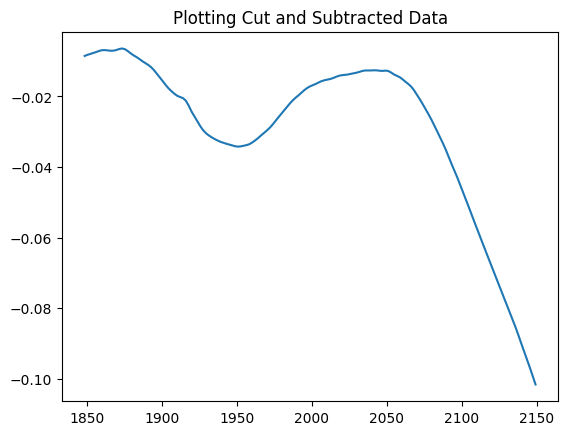

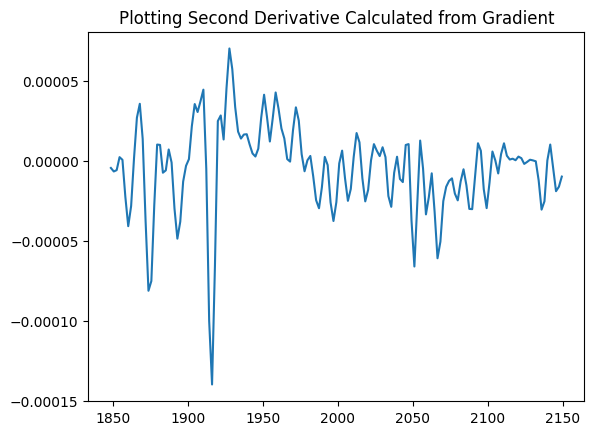

pD6_.0018_cut_range_sub_wv


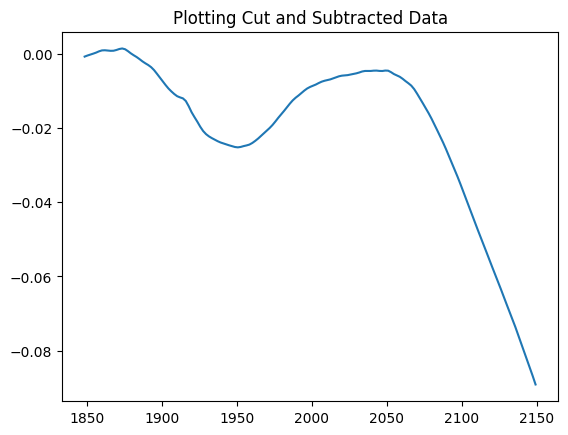

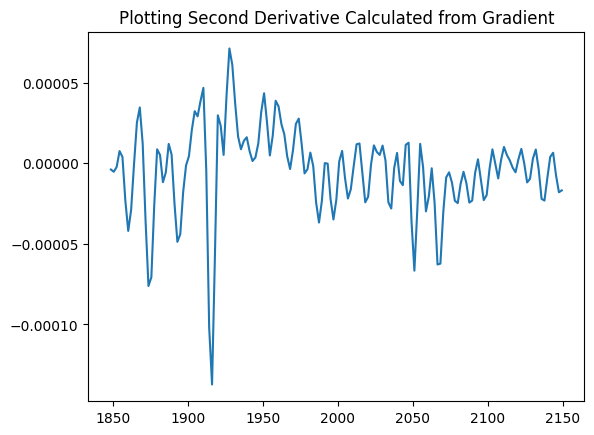

pD6_.0019_cut_range_sub_wv


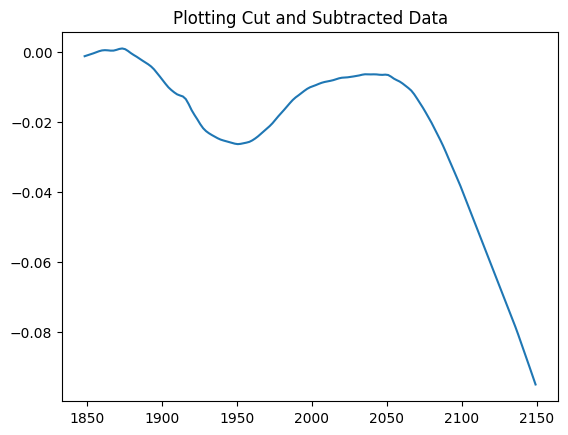

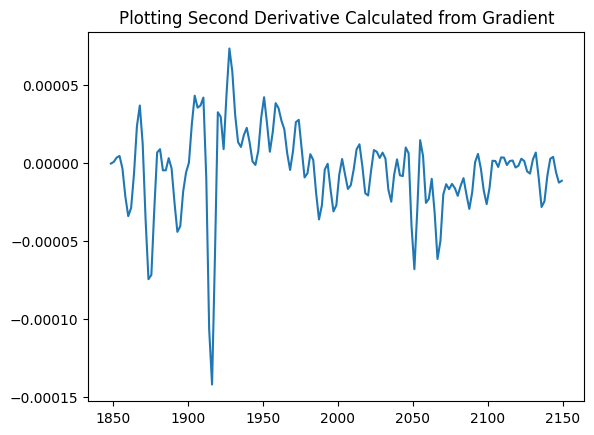

pD6_.0020_cut_range_sub_wv


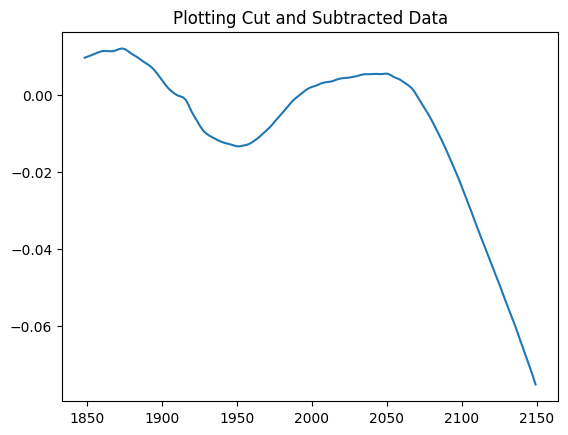

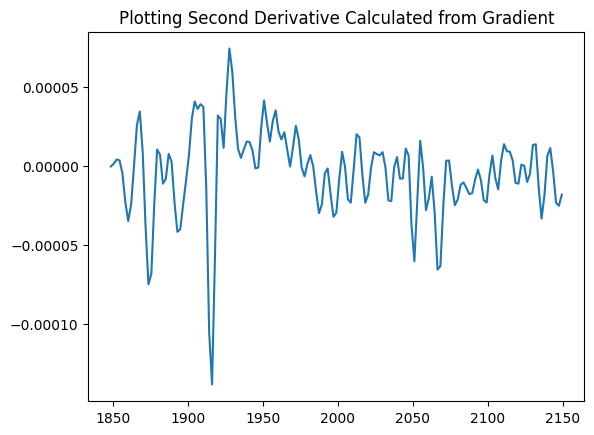

pD6_.0021_cut_range_sub_wv


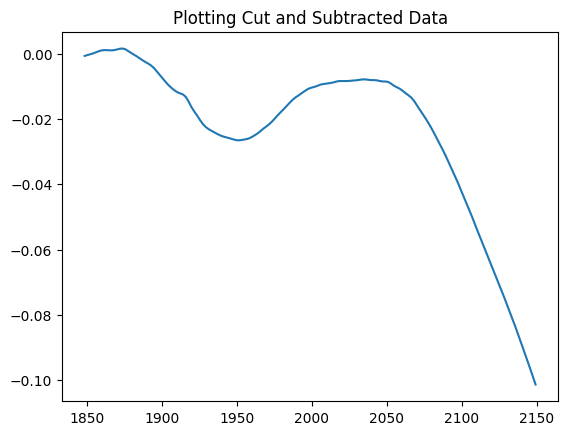

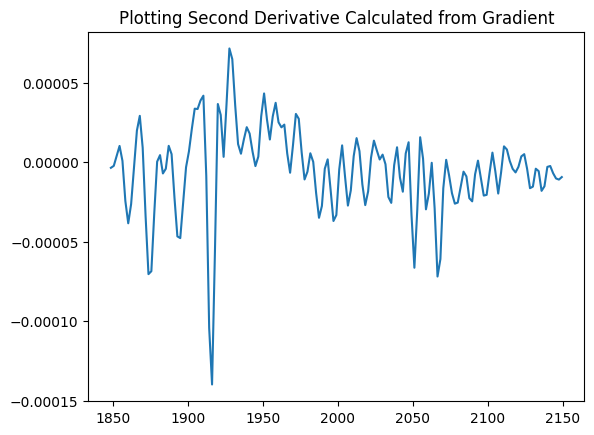

pD6_.0022_cut_range_sub_wv


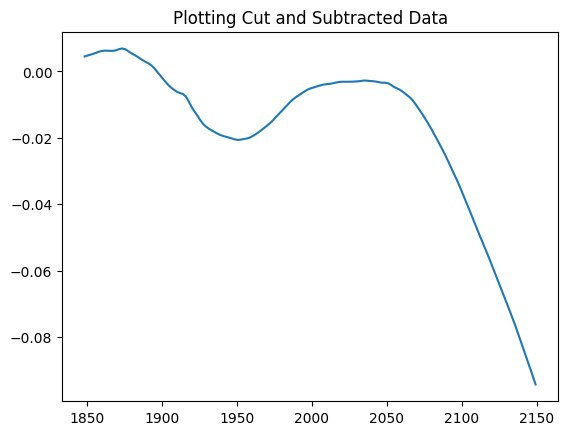

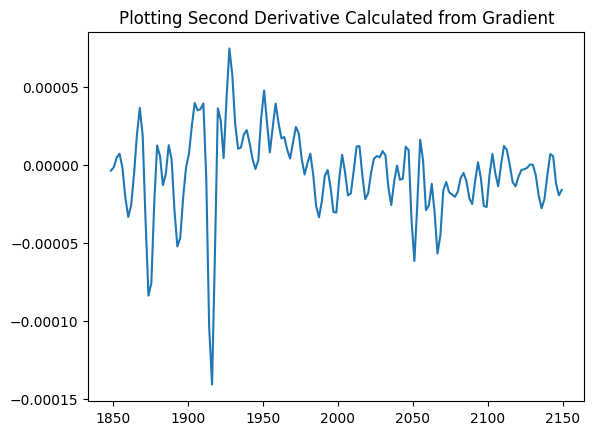

pD6_.0023_cut_range_sub_wv


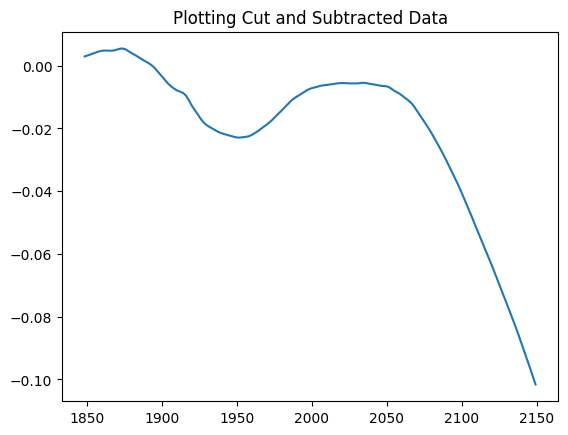

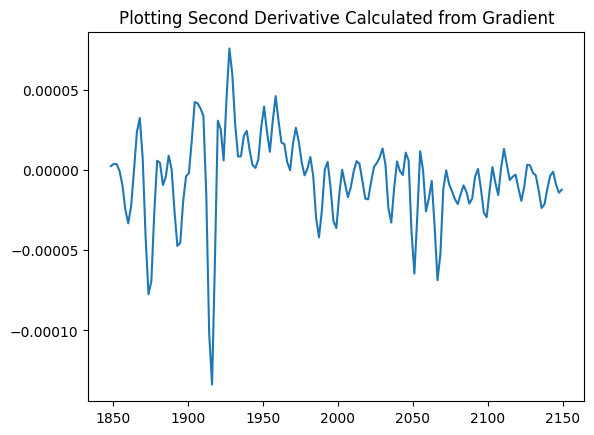

pD6_.0024_cut_range_sub_wv


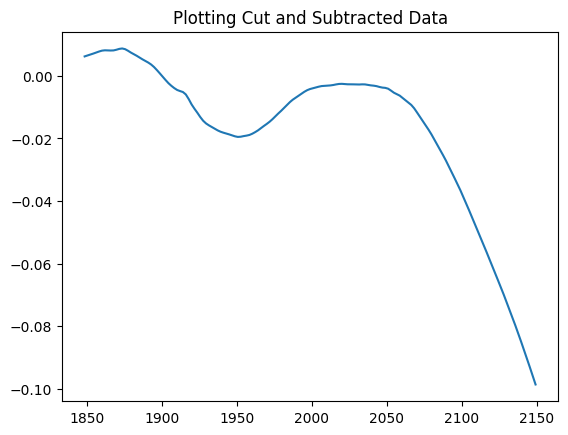

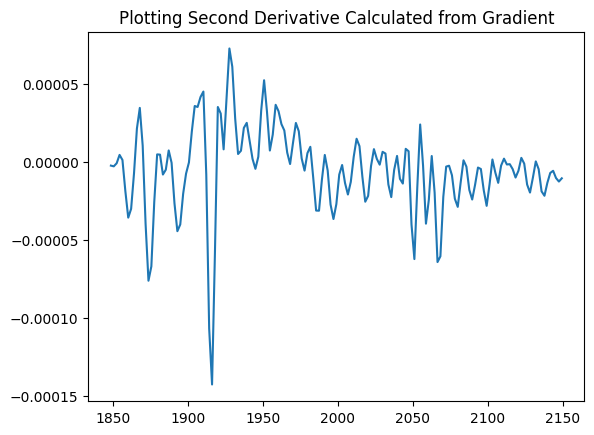

pD6_.0025_cut_range_sub_wv


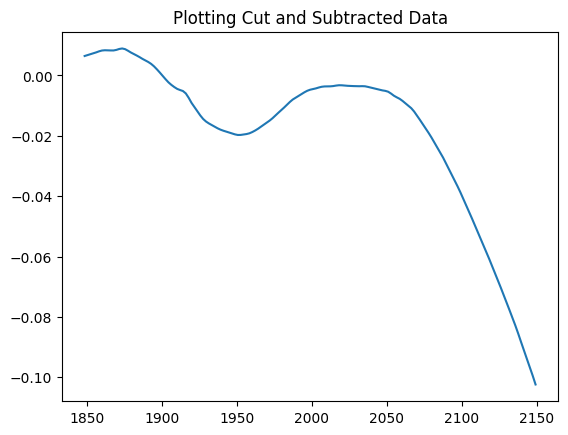

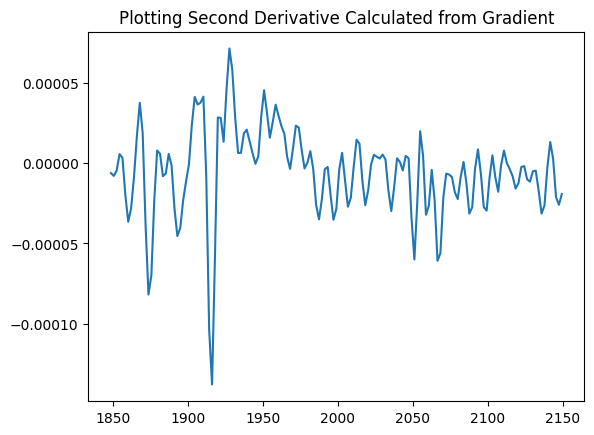

pD6_OCP.0_cut_range_sub_wv


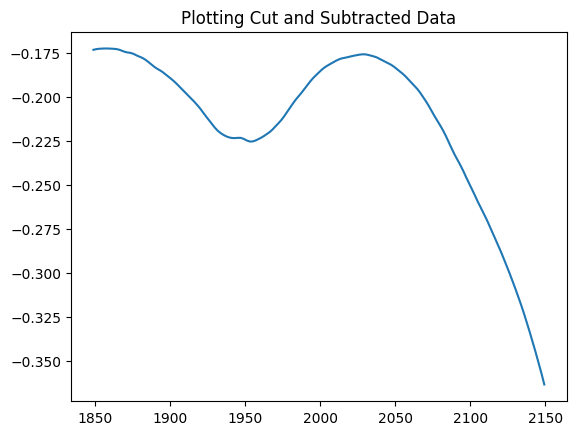

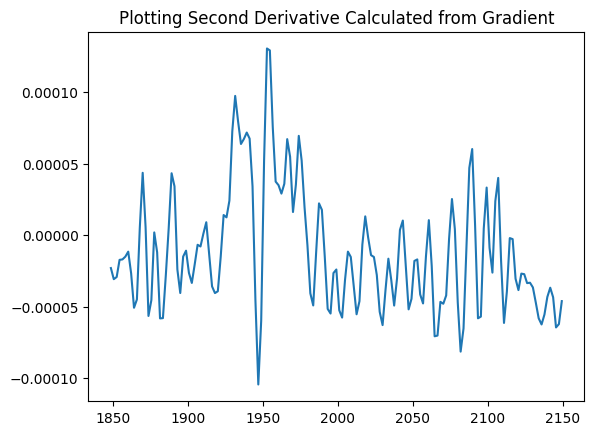

In [7]:
#Creating Empty Dict for second derivative of cut and subtracted data
second_deriv_pD6_data = dict()

#Filling it with second derivatives of all the data
for i in cut_range_sub_wv_data:
    cut_range_sub_wv_data_i = cut_range_sub_wv_data[i]
    print(i)
    second_deriv_pD6_data[f'{i}_second_deriv'] = second_deriv(cut_range_sub_wv_data_i)
